Simulation with data from Null Hypothesis (mean = 0):
Results from 10 simulations:
  Accept H0: 10 (100.0%)
  Reject H0: 0 (0.0%)
  Continue sampling: 0 (0.0%)
Average stopping point: 5.5 samples


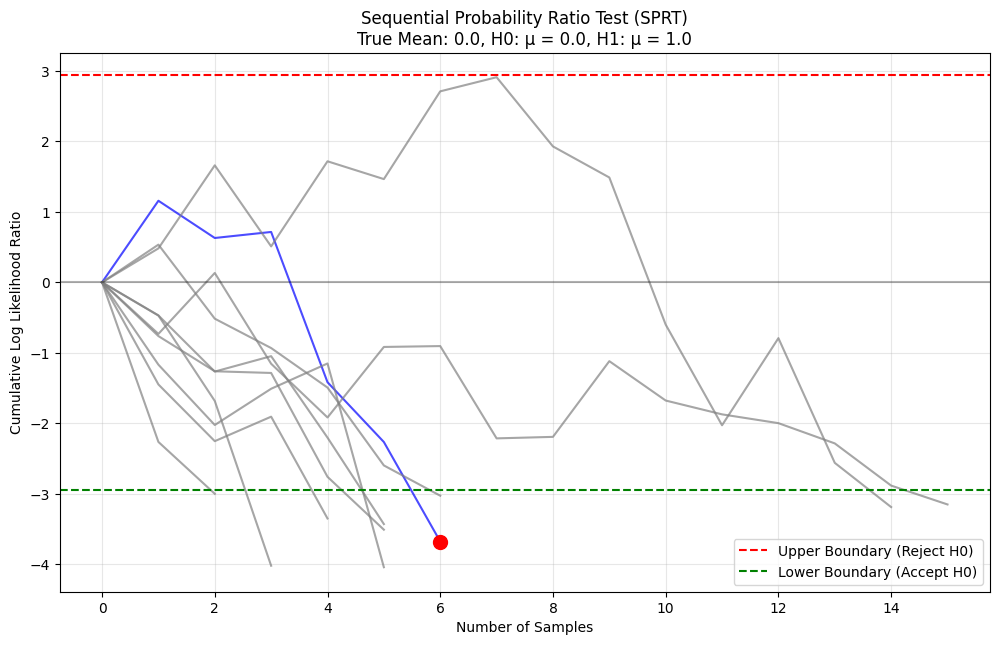


Simulation with data from Alternative Hypothesis (mean = 1):
Results from 10 simulations:
  Accept H0: 0 (0.0%)
  Reject H0: 10 (100.0%)
  Continue sampling: 0 (0.0%)
Average stopping point: 5.4 samples


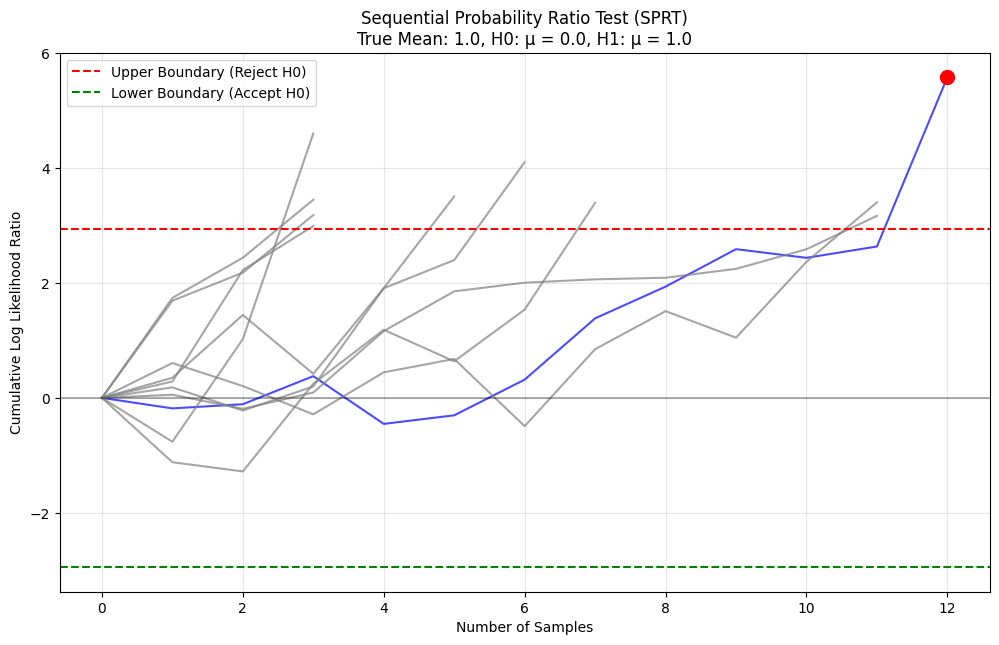


Simulation with data from Intermediate value (mean = 0.5):
Results from 10 simulations:
  Accept H0: 5 (50.0%)
  Reject H0: 5 (50.0%)
  Continue sampling: 0 (0.0%)
Average stopping point: 10.7 samples


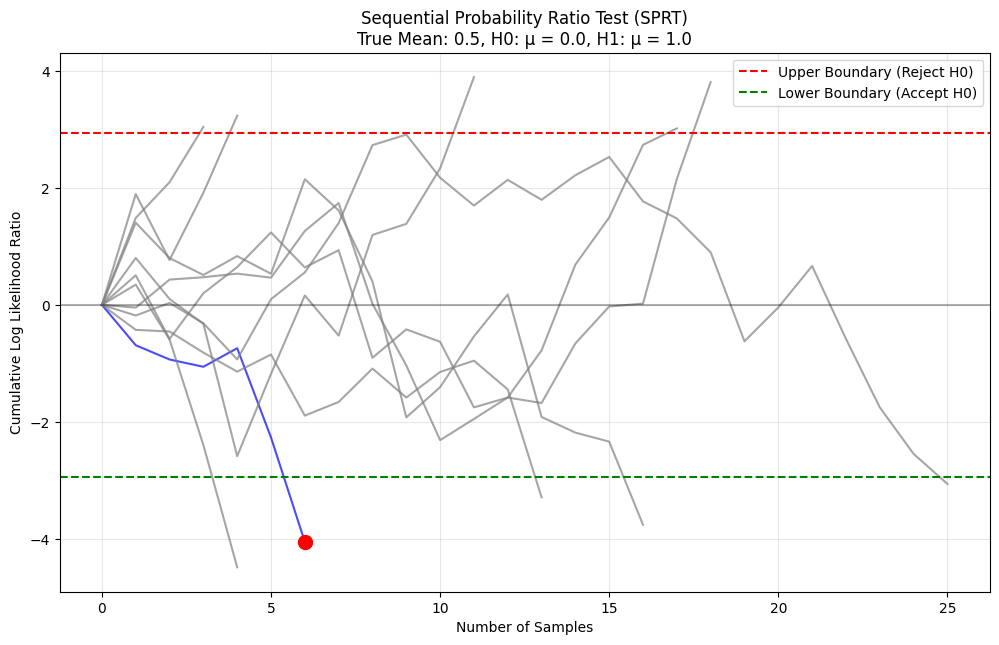

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def sequential_probability_ratio_test(data, mu0, mu1, sigma, alpha, beta):
    """
    Implement a Sequential Probability Ratio Test (SPRT)

    Parameters:
    -----------
    data: array-like
        The sequence of observations
    mu0: float
        The mean under the null hypothesis
    mu1: float
        The mean under the alternative hypothesis
    sigma: float
        Known standard deviation of the data
    alpha: float
        Type I error rate (false positive)
    beta: float
        Type II error rate (false negative)

    Returns:
    --------
    decision: str
        'Accept H0', 'Reject H0', or 'Continue sampling'
    stopping_index: int
        The index at which a decision was made, or None if no decision
    """
    A = beta / (1 - alpha)  # Lower boundary
    B = (1 - beta) / alpha  # Upper boundary

    likelihood_ratio = 1.0
    log_likelihood_ratios = [0]

    for i, x in enumerate(data):
        # Calculate likelihood ratio for this observation
        likelihood_0 = stats.norm.pdf(x, mu0, sigma)
        likelihood_1 = stats.norm.pdf(x, mu1, sigma)

        # Update the cumulative likelihood ratio
        likelihood_ratio *= (likelihood_1 / likelihood_0)
        log_likelihood_ratios.append(np.log(likelihood_ratio))

        # Check if we've crossed a boundary
        if likelihood_ratio <= A:
            return "Accept H0", i, log_likelihood_ratios
        elif likelihood_ratio >= B:
            return "Reject H0", i, log_likelihood_ratios

    return "Continue sampling", None, log_likelihood_ratios

def simulate_sequential_test(true_mean, n_samples=100, n_simulations=1):
    """
    Simulate sequential testing with generated data

    Parameters:
    -----------
    true_mean: float
        The actual mean used to generate data
    n_samples: int
        Maximum number of samples to generate
    n_simulations: int
        Number of simulations to run
    """
    # Test parameters
    mu0 = 0.0       # Null hypothesis mean
    mu1 = 1.0       # Alternative hypothesis mean
    sigma = 1.0     # Standard deviation
    alpha = 0.05    # Type I error rate
    beta = 0.05     # Type II error rate

    # Plot setup
    plt.figure(figsize=(12, 7))

    results = []
    stopping_points = []

    for sim in range(n_simulations):
        # Generate data from normal distribution with the true mean
        data = np.random.normal(true_mean, sigma, n_samples)

        # Run sequential test
        decision, stopping_idx, log_ratios = sequential_probability_ratio_test(
            data, mu0, mu1, sigma, alpha, beta
        )

        # Store results
        results.append(decision)
        stopping_points.append(stopping_idx if stopping_idx is not None else n_samples)

        # Calculate boundaries for plotting
        upper_bound = np.log((1 - beta) / alpha)
        lower_bound = np.log(beta / (1 - alpha))

        # Plot this simulation path
        x_vals = np.arange(len(log_ratios))
        plt.plot(x_vals, log_ratios, alpha=0.7, color='blue' if sim == 0 else 'gray')

        # Highlight the stopping point for the first simulation
        if sim == 0 and stopping_idx is not None:
            plt.scatter([stopping_idx+1], [log_ratios[stopping_idx+1]],
                        color='red', s=100, zorder=5)

    # Add horizontal lines for boundaries
    plt.axhline(y=upper_bound, color='r', linestyle='--', label='Upper Boundary (Reject H0)')
    plt.axhline(y=lower_bound, color='g', linestyle='--', label='Lower Boundary (Accept H0)')
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)

    # Finalize the plot
    plt.xlabel('Number of Samples')
    plt.ylabel('Cumulative Log Likelihood Ratio')
    plt.title(f'Sequential Probability Ratio Test (SPRT)\nTrue Mean: {true_mean}, H0: μ = {mu0}, H1: μ = {mu1}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Print summary statistics
    decisions = np.array(results)
    accept_h0 = np.sum(decisions == "Accept H0")
    reject_h0 = np.sum(decisions == "Reject H0")
    continue_sampling = np.sum(decisions == "Continue sampling")

    print(f"Results from {n_simulations} simulations:")
    print(f"  Accept H0: {accept_h0} ({accept_h0/n_simulations*100:.1f}%)")
    print(f"  Reject H0: {reject_h0} ({reject_h0/n_simulations*100:.1f}%)")
    print(f"  Continue sampling: {continue_sampling} ({continue_sampling/n_simulations*100:.1f}%)")
    print(f"Average stopping point: {np.mean(stopping_points):.1f} samples")

    return plt, results, stopping_points

# Example usage
if __name__ == "__main__":
    # Try with data from the null hypothesis
    print("Simulation with data from Null Hypothesis (mean = 0):")
    plt, results_h0, stops_h0 = simulate_sequential_test(true_mean=0.0, n_samples=100, n_simulations=10)
    plt.show()

    # Try with data from the alternative hypothesis
    print("\nSimulation with data from Alternative Hypothesis (mean = 1):")
    plt, results_h1, stops_h1 = simulate_sequential_test(true_mean=1.0, n_samples=100, n_simulations=10)
    plt.show()

    # Try with an intermediate value
    print("\nSimulation with data from Intermediate value (mean = 0.5):")
    plt, results_mid, stops_mid = simulate_sequential_test(true_mean=0.5, n_samples=100, n_simulations=10)
    plt.show()

Running Bayesian sequential test simulations...


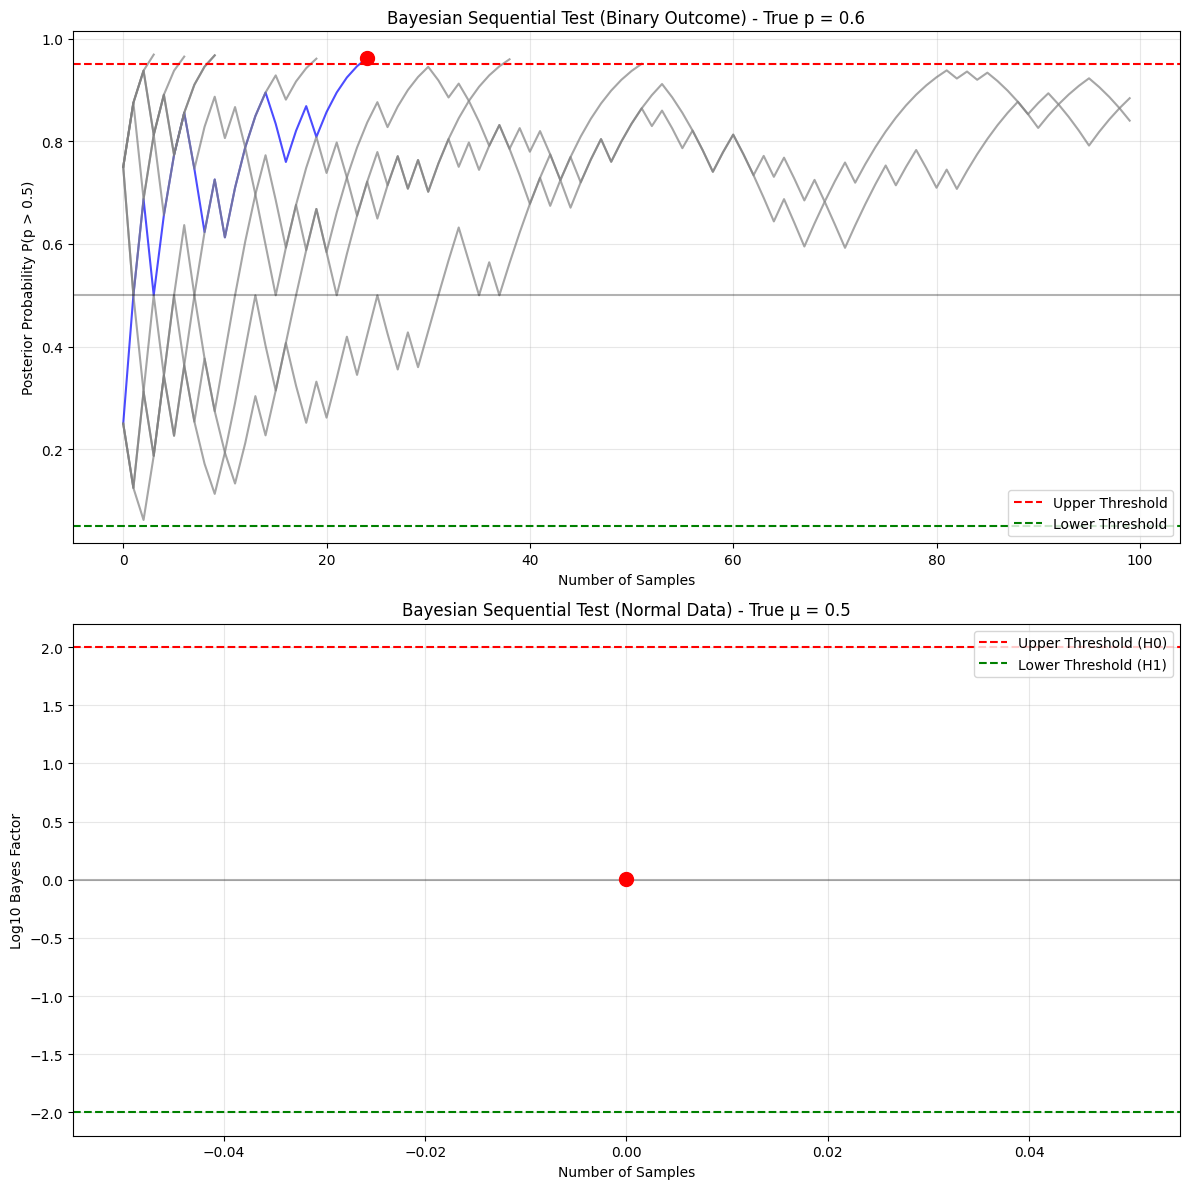


Visualizing prior to posterior evolution...


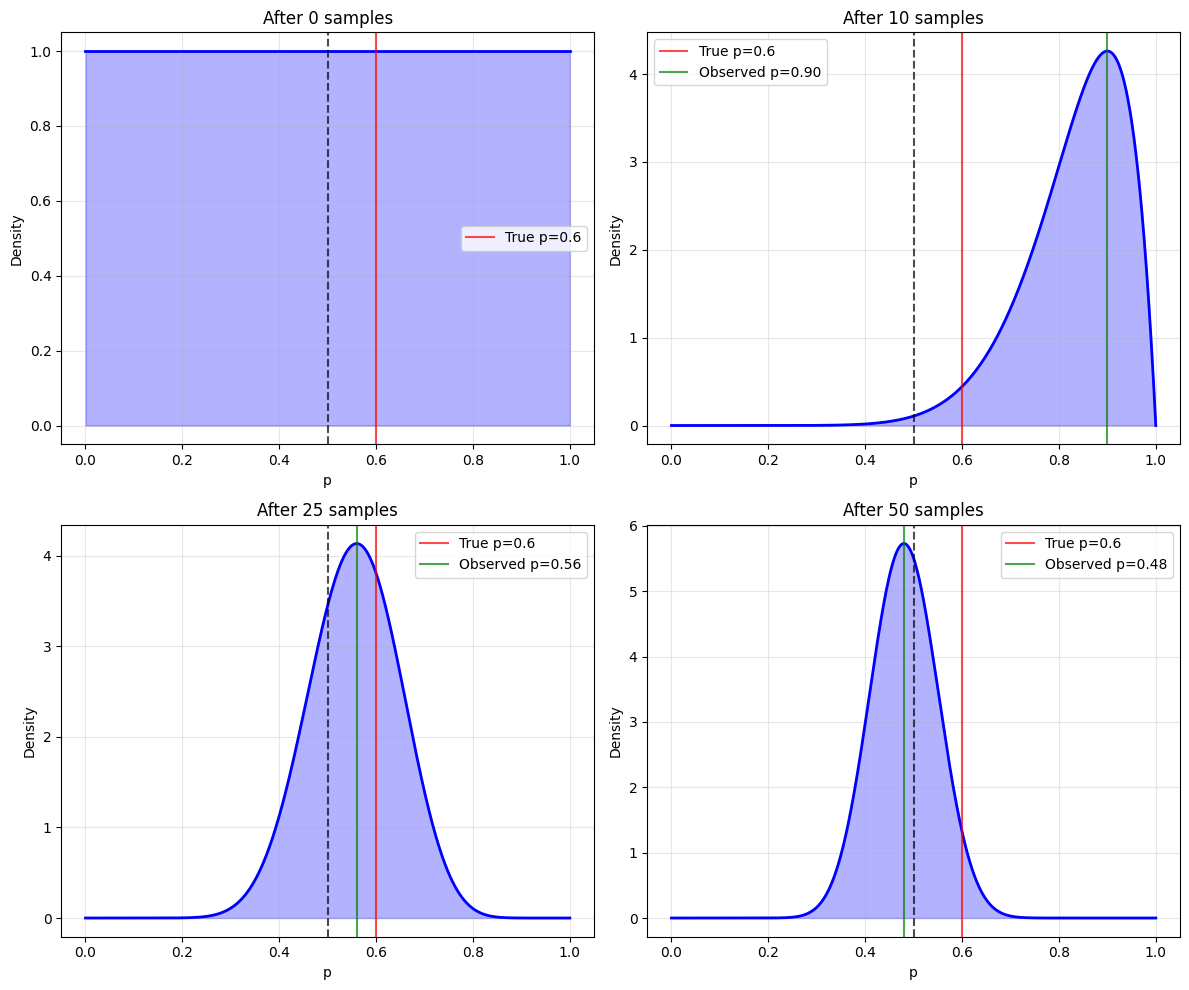


Comparing different true parameters...
Binary test with p=0.3 (favoring H0):
H0: 98, H1: 2, Continue: 0

Binary test with p=0.7 (favoring H1):
H0: 2, H1: 98, Continue: 0


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import beta, norm

def bayesian_sequential_test(data, threshold=0.95, prior_alpha=1, prior_beta=1):
    """
    Bayesian sequential test for comparing two alternatives

    Parameters:
    -----------
    data: array-like
        The sequence of observations (binary outcomes: 0 or 1)
    threshold: float
        Posterior probability threshold for making a decision
    prior_alpha, prior_beta: float
        Parameters of the Beta prior distribution

    Returns:
    --------
    decision: str
        'H0' (p <= 0.5), 'H1' (p > 0.5), or 'Continue'
    stopping_index: int
        The index at which a decision was made
    posteriors: list
        History of posterior probabilities
    """
    posteriors = []
    alpha = prior_alpha
    beta_param = prior_beta

    for i, x in enumerate(data):
        # Update parameters of the Beta distribution
        if x == 1:
            alpha += 1
        else:
            beta_param += 1

        # Calculate posterior probability that p > 0.5
        posterior_prob_h1 = 1 - beta.cdf(0.5, alpha, beta_param)
        posteriors.append(posterior_prob_h1)

        # Check if we've crossed a threshold
        if posterior_prob_h1 > threshold:
            return "H1", i, posteriors
        elif posterior_prob_h1 < (1 - threshold):
            return "H0", i, posteriors

    return "Continue", None, posteriors

def bayesian_normal_sequential_test(data, mu0=0, sigma=1, prior_mu=0, prior_sigma=1, threshold=0.99):
    """
    Bayesian sequential test for normal data with known variance

    Parameters:
    -----------
    data: array-like
        The sequence of observations
    mu0: float
        The mean under the null hypothesis
    sigma: float
        Known standard deviation of the data
    prior_mu, prior_sigma: float
        Parameters of the Normal prior distribution
    threshold: float
        Bayes factor threshold for making a decision

    Returns:
    --------
    decision: str
        'H0', 'H1', or 'Continue'
    stopping_index: int
        The index at which a decision was made
    bayes_factors: list
        History of Bayes factors
    """
    bayes_factors = []

    # Initialize running sums
    sum_x = 0
    n = 0

    for i, x in enumerate(data):
        n += 1
        sum_x += x

        # Update posterior parameters
        posterior_var = 1 / (1/prior_sigma**2 + n/sigma**2)
        posterior_mean = posterior_var * (prior_mu/prior_sigma**2 + sum_x/sigma**2)

        # Calculate Bayes factor (H1: μ ≠ μ0 vs H0: μ = μ0)
        # This is an approximation using Savage-Dickey density ratio
        posterior_density_at_mu0 = norm.pdf(mu0, posterior_mean, np.sqrt(posterior_var))
        prior_density_at_mu0 = norm.pdf(mu0, prior_mu, prior_sigma)
        bf = prior_density_at_mu0 / posterior_density_at_mu0

        bayes_factors.append(bf)

        # Make decision based on threshold
        if bf > threshold:
            return "H0", i, bayes_factors
        elif bf < 1/threshold:
            return "H1", i, bayes_factors

    return "Continue", None, bayes_factors

def simulate_bayesian_tests(n_samples=100, n_simulations=10):
    """
    Simulate both binary and normal Bayesian sequential tests
    """
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Simulation 1: Binary data (Beta-Bernoulli)
    true_p = 0.6  # True probability of success

    for sim in range(n_simulations):
        data = np.random.binomial(1, true_p, n_samples)
        decision, stop_idx, posteriors = bayesian_sequential_test(data)

        color = 'blue' if sim == 0 else 'gray'
        ax1.plot(range(len(posteriors)), posteriors, alpha=0.7, color=color)

        if sim == 0 and stop_idx is not None:
            ax1.scatter([stop_idx], [posteriors[stop_idx]], color='red', s=100, zorder=5)

    ax1.axhline(y=0.95, color='r', linestyle='--', label='Upper Threshold')
    ax1.axhline(y=0.05, color='g', linestyle='--', label='Lower Threshold')
    ax1.axhline(y=0.5, color='k', linestyle='-', alpha=0.3)
    ax1.set_xlabel('Number of Samples')
    ax1.set_ylabel('Posterior Probability P(p > 0.5)')
    ax1.set_title(f'Bayesian Sequential Test (Binary Outcome) - True p = {true_p}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Simulation 2: Normal data
    true_mu = 0.5  # True mean

    for sim in range(n_simulations):
        data = np.random.normal(true_mu, 1, n_samples)
        decision, stop_idx, bayes_factors = bayesian_normal_sequential_test(data)

        color = 'blue' if sim == 0 else 'gray'
        log_bf = np.log10(bayes_factors)
        ax2.plot(range(len(log_bf)), log_bf, alpha=0.7, color=color)

        if sim == 0 and stop_idx is not None:
            ax2.scatter([stop_idx], [log_bf[stop_idx]], color='red', s=100, zorder=5)

    threshold_log = np.log10(100)  # Corresponding to threshold=100
    ax2.axhline(y=threshold_log, color='r', linestyle='--', label='Upper Threshold (H0)')
    ax2.axhline(y=-threshold_log, color='g', linestyle='--', label='Lower Threshold (H1)')
    ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    ax2.set_xlabel('Number of Samples')
    ax2.set_ylabel('Log10 Bayes Factor')
    ax2.set_title(f'Bayesian Sequential Test (Normal Data) - True μ = {true_mu}')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig, ax1, ax2

def plot_prior_posterior_evolution(n_samples=50):
    """
    Visualize how the prior evolves into the posterior over time
    """
    true_p = 0.6
    data = np.random.binomial(1, true_p, n_samples)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    # Sample points to show evolution
    plot_points = [0, 10, 25, n_samples]

    alpha_init, beta_init = 1, 1  # Uniform prior
    alpha, beta_param = alpha_init, beta_init

    x = np.linspace(0, 1, 1000)

    for i, point in enumerate(plot_points):
        # Update parameters based on data up to this point
        successes = sum(data[:point])
        failures = point - successes

        alpha = alpha_init + successes
        beta_param = beta_init + failures

        # Plot the distribution
        y = beta.pdf(x, alpha, beta_param)
        axes[i].plot(x, y, color='blue', linewidth=2)
        axes[i].fill_between(x, y, alpha=0.3, color='blue')
        axes[i].axvline(x=0.5, color='black', linestyle='--', alpha=0.7)
        axes[i].axvline(x=true_p, color='red', linestyle='-', alpha=0.7, label=f'True p={true_p}')

        if point > 0:
            observed_p = successes / point
            axes[i].axvline(x=observed_p, color='green', linestyle='-', alpha=0.7, label=f'Observed p={observed_p:.2f}')

        axes[i].set_title(f'After {point} samples')
        axes[i].set_xlabel('p')
        axes[i].set_ylabel('Density')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    return fig, axes

# Example usage
if __name__ == "__main__":
    # Simulate Bayesian sequential tests
    print("Running Bayesian sequential test simulations...")
    fig, ax1, ax2 = simulate_bayesian_tests(n_samples=100, n_simulations=10)
    plt.show()

    # Show prior to posterior evolution
    print("\nVisualizing prior to posterior evolution...")
    fig2, axes = plot_prior_posterior_evolution(n_samples=50)
    plt.show()

    # Compare with different true parameters
    print("\nComparing different true parameters...")

    # Binary test with p=0.3 (favoring H0)
    print("Binary test with p=0.3 (favoring H0):")
    results_h0 = []
    for _ in range(100):
        data = np.random.binomial(1, 0.3, 100)
        decision, stop_idx, _ = bayesian_sequential_test(data)
        results_h0.append(decision)
    print(f"H0: {results_h0.count('H0')}, H1: {results_h0.count('H1')}, Continue: {results_h0.count('Continue')}")

    # Binary test with p=0.7 (favoring H1)
    print("\nBinary test with p=0.7 (favoring H1):")
    results_h1 = []
    for _ in range(100):
        data = np.random.binomial(1, 0.7, 100)
        decision, stop_idx, _ = bayesian_sequential_test(data)
        results_h1.append(decision)
    print(f"H0: {results_h1.count('H0')}, H1: {results_h1.count('H1')}, Continue: {results_h1.count('Continue')}")